### Abstract
There are 6 parts in this notebook.

1.Introduction

2.Object Classes and Global Variables

3.Dataset Illustration

4.Helper Functions for Visualization

5.Helper Functions for GA model

6.Test & Visualize the Result

## 1.Introduction
### Scenario
We suppose there is a tourist who wants to visit Toronto. There are 175 attractions in our dataset. The user will input the number of traveling days, the maximum time he wants to spend per day, and a list of categories he is interested in. And our model will provide the user with a trip plan for each day. 
### Constraints
No duplicate place among all the plans.

Total time (Commute time + Duration time) should be less than the maximum time.
### Math formulation & Notations
Total idle time (to be minimized):

$𝑓_{0}= T_{max} - \sum\limits_{Pi=1}^{Pn}T_{d} - \sum\limits_{Pi=1}^{Pn}T_{ij}$

Total commute time (to be minimized):

$𝑓_{1}= \sum\limits_{Pi=1}^{Pn}T_{ij}$

Average attraction level (to be maxmized):

$𝑓_{2}= 1/size(P_{s})\sum\limits_{Pi=1}^{Pn}S_{i}$

Total attraction level (to be maxmized):

$𝑓_{3}= \sum\limits_{Pi=1}^{Pn}S_{i}$

Fitness value:

$𝑓_{fitness}= 1 + a*𝑓_{0} + b*𝑓_{1} + c*𝑓_{2} + d*𝑓_{0} $

(a < b < 0, c>0, d>0, c + d =1)
### Where

$P_{s}$ = selected places in the chromosome

$T_{max}$ = maximum time for each day

$T_{d} $ = total duration time

$T_{ij}$ = commute time from place i to place j

$S_{i}$ = place i's attraction level

## 2. Object Classes and Global Variables
To build the model in the touring problem scope, we first define a class called "Place" to store each place of interest in the dataset. By eliminating unrelated features, we choose "index","name", "attraction level", "location"，“cluster” and "category" attribute for each places. A Place object is allowed to modify its attraction level.


Object 'Chromosome' has two variables "places" and "fitness". "places" is an ordered list of Places And "fitness" is an evaluation value of the quality of selected places.


Global variable 'route_duration_matrix' is a matrix used to store commute time from col[i] to row[j]. 

The route_to_dest function can use stored commute time directly from our matrix instead of making a JSON request if we have already searched for that. In this way, the total running time will be reduced.

In [191]:
import requests
import time
import numpy as np
import pandas as pd
import random 


route_duration_matrix = np.zeros((200,200))

class Place:
    def __init__(self, name, attract_level, latitude, longitude, category,index):
        self.name = name
        self.attract_level = attract_level
        self.location = (float(longitude), float(latitude))
        self.category = category
        self.time = int(np.random.normal(110,30))
        
        #new added
        self.cluster = 0 
        self.index = index
        self.commute_time = 0
        
    def modify_attract_level(self, k):
        self.attract_level *= k
        
    
    def route_to(self, destination, mode = "driving"):
        src = self.location
        dest = destination.location
                
        response = requests.get(f'http://router.project-osrm.org/route/v1/{mode}/{src[1]},{src[0]};{dest[1]},{dest[0]}?steps=true')
        response_json = response.json()

        if response_json['code'] != 'Ok':
            raise ValueError(f"OSRM couldn't find a route between {src} and {dest}")

        route = response_json["routes"][0]
        cost = route["distance"]
        duration = route["duration"]
        legs = route["legs"][0]
        steps = legs["steps"]

        route_coords = list()
        for route_step in steps:
            maneuver = route_step["maneuver"]
            location = maneuver["location"]
            location = location[::-1]   # from (longitude, latitude) to (latitude, longitude) so ipyleaflet can handle it
            route_coords.append(tuple(location))
        
        return {'coords' : route_coords, 
                'length' : cost,
                'duration' : duration}
    
    #simplified route_to function, 
    #it will check whether there is a corresponding duration value in globle matrix before make a request
    def route_to_dest(self, destination, mode = "driving"):
        global route_duration_matrix
        src = self.location
        dest = destination.location
        
        if route_duration_matrix[self.index][destination.index]!=0:
            return {'coords' : ' ', 
                    'length' : 0,
                    'duration' : route_duration_matrix[self.index][destination.index]}     

        response = requests.get(f'http://router.project-osrm.org/route/v1/{mode}/{src[1]},{src[0]};{dest[1]},{dest[0]}?steps=true')
        response_json = response.json()

        if response_json['code'] != 'Ok':
            raise ValueError(f"OSRM couldn't find a route between {src} and {dest}")

        route = response_json["routes"][0]
        cost = route["distance"]
        duration = route["duration"]

        route_coords = list() 
        #assign duration to corresponding position of the globle matrix
        route_duration_matrix[self.index][destination.index] = duration
     
        return {'coords' : route_coords, 
                'length' : cost,
                'duration' : duration}
    
    #Chromosome = an array of places + fitness value
class Chromosome:
    def __init__(self,places,fitness):
        self.places = places
        self.fitness = fitness

## 3.Dataset illustration

Here we import dataset from places.csv and pre-process the data.

Extract data from dataset into a list of Place objects.

In [192]:

path = "places.csv"
df = pd.read_csv(path)

places = []

for i in range(len(df)):
    # extract the geometry detail
    location_str = df['geometry'][i].split('(')[-1][:-2]
    latitude = location_str.split(', ')[0]
    longitude = location_str.split(', ')[1]
    name = df['NAME'][i]
    attract_level = df['ATTRACTION_LEVEL'][i]
    category = df['CATEGORY'][i]
    #use i as index
    places.append(Place(name, attract_level, latitude, longitude, category,i))


In [193]:
src, dest = places[0], places[1]
route = src.route_to(dest)
route

{'coords': [(43.632235, -79.418479),
  (43.63202, -79.419539),
  (43.630918, -79.419736),
  (43.630545, -79.419808),
  (43.631509, -79.429306),
  (43.632844, -79.428636),
  (43.649601, -79.350287),
  (43.720618, -79.3292),
  (43.722328, -79.328383),
  (43.723869, -79.327203),
  (43.724548, -79.324575),
  (43.724119, -79.325046),
  (43.727386, -79.327702),
  (43.725873, -79.33313)],
 'length': 19647.2,
 'duration': 1143.5}

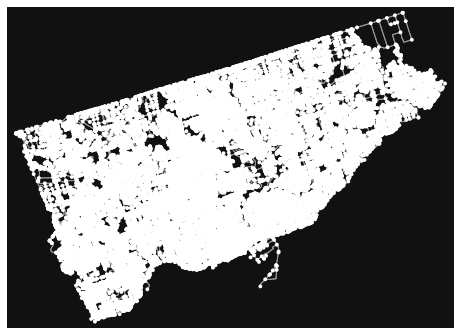

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [156]:
import osmnx as ox
from collections import deque
import networkx as nx
ox.config(log_console=True, use_cache=True) 
# from tqdm import tqdm
# from utilities import *
G = ox.graph_from_place("Toronto, Canada", network_type='drive')
ox.plot_graph(G)

Here are all the location plots for our dataset.

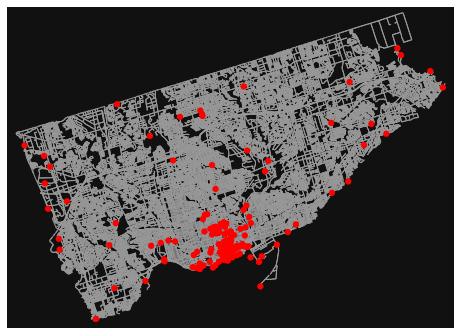

In [7]:
highlighted = []
for place in places:
    highlighted.append(ox.distance.get_nearest_node(G, place.location))

nc = ['r' if node in highlighted else '#336699' for node in G.nodes()]
ns = [40 if node in highlighted else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2) 

## 4.Helper Functions for Visualization
'classifyPOIs' function is used to distribute each place into corresponding cluster.
and update the cluster value of each place

'plotByCluster' function is used to plot all points by clusters and each cluster with a unique color.

'highlightMustSee' function is used to plot mustsee POIs with their corresponding colors.

'draw_route' function is used to draw routes for the input places in array's ascending order.
(start point is hard-coded)

In [364]:
from sklearn.cluster import KMeans
import numpy as np
#classifyPOIs function will update the cluster value of place objects
#Requires to input the number of clusters, an array of object places
#returns a list of places
def classifyPOIs(n, places):
    POIs = []
    for place in places:      
        POIs.append(place.location)
    kmeans = KMeans(n_clusters = n, random_state = 0).fit(POIs)
    
    #update cluster value of each place object
    i = 0
    for place in places:
        place.cluster = kmeans.labels_[i]
        i += 1       
    return places

#plotByCluster function will plot POIs up to the nth clusters 
#Requires to input the number of clusters (<7), an array of object places
def plotByCluster(n,places):
    #create cluster arrays
    all_cluster = [[] for i in range(7)]
    #update each node into corresponding cluster
    for i in range(n):
        for place in places:
            if place.cluster == i :
                all_cluster[i].append(ox.distance.get_nearest_node(G, place.location))
    cluster_nc = []
    for node in G.nodes():
        if node in all_cluster[0]:
            cluster_nc.append('r')
        elif node in all_cluster[1]:
            cluster_nc.append('#1BF5DB')
        elif node in all_cluster[2]:
            cluster_nc.append('#f1f10a')
        elif node in all_cluster[3]:
            cluster_nc.append('#f10ada')
        elif node in all_cluster[4]:
            cluster_nc.append('#F1990A')
        elif node in all_cluster[5]:
            cluster_nc.append('b')
        elif node in all_cluster[6]:
            cluster_nc.append('g')
        else:
            cluster_nc.append('#336699')      
    ns = [25 if node in highlighted else 0 for node in G.nodes()]
    fig, ax = ox.plot_graph(G, node_size=ns, node_color=cluster_nc)


def highlightMustSee(n, places):
    highest_level = 0
    #find the highest attraction level
    MustSeePlaces = []
    for place in places:
        if place.attract_level>=highest_level:
            highest_level = place.attract_level
            MustSeePlaces.append(place)
            
    all_cluster = [[] for i in range(7)]
    #update each must See into corresponding cluster
    for i in range(n):
        for place in MustSeePlaces:
            if place.cluster == i and place.attract_level == highest_level:
                all_cluster[i].append(ox.distance.get_nearest_node(G, place.location))
    cluster_nc = []
    for node in G.nodes():
        if node in all_cluster[0]:
            cluster_nc.append('r')
        elif node in all_cluster[1]:
            cluster_nc.append('#1BF5DB')
        elif node in all_cluster[2]:
            cluster_nc.append('#f1f10a')
        elif node in all_cluster[3]:
            cluster_nc.append('#f10ada')
        elif node in all_cluster[4]:
            cluster_nc.append('#F1990A')
        elif node in all_cluster[5]:
            cluster_nc.append('b')
        elif node in all_cluster[6]:
            cluster_nc.append('g')
        else:
            cluster_nc.append('#336699')      
    ns = [25 if node in highlighted else 0 for node in G.nodes()]
    fig, ax = ox.plot_graph(G, node_size=ns, node_color=cluster_nc)

#draw_route function requie input an ordered list of places and a Map G
#Then it will draw the shortest path between each places on the Map G
#assumes there are 4 places in the input list
def draw_route(places,G):
    #here we hardcoded the start point
    start_point = Place('start point', 0, -79.4256383116, 43.6510026743, 'start point', 199)
    orig = ox.distance.get_nearest_node(G, start_point.location)
    dest1 = ox.distance.get_nearest_node(G, places[0].location)
    dest2 = ox.distance.get_nearest_node(G, places[1].location)
    dest3 = ox.distance.get_nearest_node(G, places[2].location)
    dest4 = ox.distance.get_nearest_node(G, places[3].location)
    # calculate shortest paths for each route
    route1 = nx.shortest_path(G, orig1, dest1, weight='length')
    route2 = nx.shortest_path(G, dest1, dest2, weight='length')
    route3 = nx.shortest_path(G, dest2, dest3, weight='length')
    route4 = nx.shortest_path(G, dest3, dest4, weight='length')
    route5 = nx.shortest_path(G, dest4, orig1, weight='length')
   
    # red, light blue, yellow, green, blue
    color_list =['r','#1BF5DB','#f1f10a','green','blue']
    # plot the routes
    fig, ax = ox.plot_graph_routes(G, [route1,route2,route3,route4,route5], route_colors=color_list,route_linewidth=2,node_size=0)

Here are two plotting examples of above funtions

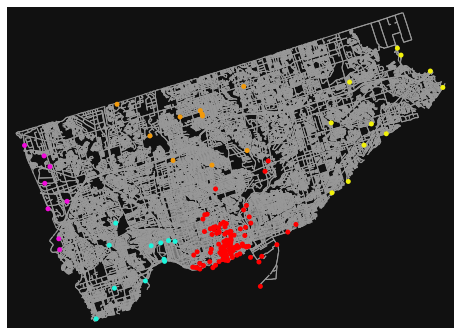

In [10]:
places = classifyPOIs(5,places)
plotByCluster(5,places)

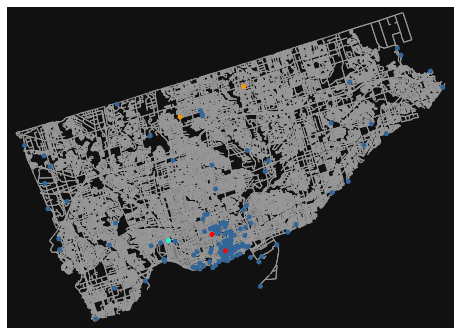

In [47]:
highlightMustSee(5,places)

## 5. Helper functions for GA model
Most of the helper functions here are sub procedures of the genetic algorithm such as initizing population, mutation, crossover and computing the fitness value. 
We are using two point crossover for crossover operations. restting mutation and swap mutation will be used for mutation operations. To compute the fitness of each solution, we are taking consider of the average attractive level, total transit time and the idle time.

Apart from those sub procedures, 'BestPOIs' function is used to figure out the best cluster for each day's GA iterations.

'computeTotalTime' is used to calculate the sum of total commute time and duration time of an input places list.


In [351]:

#BestPOIs function requires to input an integer(days) and a list of places
#it will find the cluster with the most mustsee POIs
#returns the best cluster(list) of the input places list
def BestPOIs(n, places):
    all_cluster = [[] for i in range(n)]   
    #find the largest attract_level value
    highest_attract_level = 0
    for place in places:
        if place.attract_level > highest_attract_level:
            highest_attract_level = place.attract_level
    #print('The highest attract_level here: ', highest_attract_level) 
    best_cluster_index = 0
    best_MustSee_count = 0
    best_cluster_average = 0
    #each loop will deal with each cluster
    for i in range(n):
        cluster_count = 0
        cluster_total_socre = 0
        cluster_average_score = 0
        cluster_MustSee_count = 0
        #update each palce into corresponding cluster, count must see POIs & average score for each cluster
        for place in places:
            if place.cluster == i and place.attract_level == highest_attract_level :
                cluster_count += 1
                all_cluster[i].append(place)
                cluster_total_socre  +=  place.attract_level
                cluster_MustSee_count+= 1
        for place in places:
            if place.cluster == i and place.attract_level != highest_attract_level and cluster_count<40:
                cluster_count += 1
                all_cluster[i].append(place)
                cluster_total_socre  +=  place.attract_level
        #compute the average attract level        
        cluster_average_score = cluster_total_socre / cluster_count
        #Compare current cluster to the best cluster
        if cluster_MustSee_count > best_MustSee_count:
            best_MustSee_count = cluster_MustSee_count
            best_cluster_index = i
            best_cluster_average = cluster_average_score
        #if there are two cluster having the same number of the must see POIS
        #select the one will the higher average attract level
        elif cluster_MustSee_count == best_MustSee_count:
            if(cluster_average_score > best_cluster_average):
                best_cluster_index = i
                best_cluster_average = cluster_average_score
        #print('For cluster ',i,'average score: ', cluster_average_score, 'number of POIs: ',cluster_count)
        #print('Must see POIs: ', cluster_MustSee_count)
    #print ('Best cluster: ',best_cluster_index)
    return all_cluster[best_cluster_index]

#computeTotalTime function requires to input a list of selected places
#it will compute total duration and commute time of input places and commute time is calculated in sequence
#returns two double variables, total_duration_time and total_commute_time
def computeTotalTime(places):
    total_duration_time = 0
    total_commute_time = 0
    start_point = Place('start point', 0, -79.4256383116, 43.6510026743, 'start point', 199)
    #initialize previous with start point
    previous = start_point
    for place in places:
        total_duration_time += place.time
        src , dest = previous , place
        route = src.route_to_dest(dest)
        #update total commute time and round up it to integer 
        total_commute_time += round(route['duration']/60,0)
        #update the current cost to this place
        place.commute_time = round(route['duration']/60,0)    
        previous = place
    #compute the commute time of back to start point
    src , dest = previous , start_point
    route = src.route_to_dest(dest)
    total_commute_time += round(route['duration']/60,0)
    #return total duration time and total commute time of a list of places
    return total_duration_time, total_commute_time


In [344]:
from copy import deepcopy
        
#init_parents reuqires to input an array of places and will return parent1, parent2 
#p1, p2 may have the same places, but each chromosome itself won't have duplicates
#p1 and p2 should within maximum total time (fitness>0)
def init_parents(places):
    p1 = []
    p2 = []
    f1 = 0
    f2 = 0
    # generate a random solution within total time
    while (f1 == 0):
        p1 = random.sample(places,4)
        f1 = compute_fitness(p1)
    parent1 = Chromosome(p1,f1)
    #for parent2
    while (f2 == 0):
        p2 = random.sample(places,4)
        f2 = compute_fitness(p2)
    parent2 = Chromosome(p2,f2)
    #remaining_places = [place for place in remaining_places if place not in parent2] 
    return parent1, parent2

#compute_fitness function requires to input an array of places and return a fitness value
#returns a double value fitness
def compute_fitness(inputplaces):
    index_array = []
    size = len(inputplaces)
    #compute total transit time, total duration time and idle time
    total_duration_time, total_commute_time = computeTotalTime(inputplaces)
    current_total_time = total_duration_time+ total_commute_time
    idle_time = 500 - current_total_time
    #compute total_level
    total_level = 0.0
    #copmute the average attract level
    for place in inputplaces:
        total_level += place.attract_level
    average_level = total_level/size
    #print('idle time:',idle_time,'current_total_time: ',current_total_time)
    #check whether meet the hard constraint within maximum time
    if idle_time < 0:
        fitness = 0
    else:
        fitness = 1 - total_commute_time/100 - 0.9*idle_time/100 + 0.5*average_level + 0.5*total_level  
    #If there are duplicate places in one chromosome, set fitness to 0
    for place in inputplaces:
        if place.index not in index_array:
            index_array.append(place.index)
        else:
            fitness = 0
    return fitness

#remove_duplicates function requires a list of places
#it will remove duplicates in an array of places
#returns a list of unique places
def remove_duplicates(places):
    #since we can not use 'not in' to deal with the list of lists case
    #put each place's index in Index array, remove the duplicate places by index
    Index = []
    temp = []
    i = 0
    size = len(places)
    for place in places:
        if place.index not in Index:
            Index.append(place.index) 
            temp.append(place)
    return temp
               
#select_parent function requires to input a list of Chromosome and the number of top N Chromosome
#returns an array of chromosomes with top n fitness value in the population
def select_parent(population, n):
    p = deepcopy(population)
    bestN = []
    for i in range(n):
        #temp is an individual in the population
        temp = p[0]
        index = 0
        #find highest fitness value in the current population
        for j in range(len(p)):
            if p[j].fitness > temp.fitness:
                temp = p[j]
                index = j
        bestN.append(temp)
        #remove the current best from the list
        p.remove(temp)
    return bestN

#select the best individual among the population
def select_best(population):
    fitness_array = []
    for chromosome in population:
        fitness_array.append(chromosome.fitness)
    index = fitness_array.index(max(fitness_array))
    best = population[index]
    return best

#crossover function requires to input 2 Chromosomes
#returns 2 Chromosomes
def crossover(parent1, parent2):
    p1 = parent1.places
    p2 = parent2.places
    p_size = np.min((len(p1), len(p2)))
    #generate two random integers and sort them as start point and endpoint
    start, end = sorted([random.randrange(p_size) for x in range(2)])
    #avoid the whole places
    if start == 0 and end == p_size-1:
        end = end - 1   
    #print(start, end)
    temp = deepcopy(p1)
    for i in range(start, end +1):
        p1[i] = p2[i]
        p2[i]=temp[i]
    cp1 = remove_duplicates(p1)
    cp2 = remove_duplicates(p2)
    #compute new fitness
    cf1 = compute_fitness(cp1)
    cf2 = compute_fitness(cp2)
    #create two new chromosome objects and return
    child1 = Chromosome(cp1,cf1)
    child2 = Chromosome(cp2,cf2)
    return child1, child2


#rest_mutation funtion requires to input a target chromosome, an array of remaining places
#which is similar to the bit flip swap
#returns a new chromosome
def rest_mutation(chromosome, places):
    replace_list = []
    replace_position = []
    cp = chromosome.places
    #aviod duplicates
    remaining_places = remove_selected_places(chromosome, places)
    #randomly pick a place from remaining places
    replace_list = random.sample(remaining_places, 1)
    #randomly pick a posistions at chromosome
    replace_position = random.sample(range(len(cp)), 1)
    count = 0
    #replace the mutated gene
    for j in range(len(cp)):
        if j in replace_position:
            cp[j] = replace_list[count]
            count += 1
    #update fitness after mutation
    cf = compute_fitness(cp)
    child = Chromosome(cp,cf)
    return child

#swap_mutation function only requires an chromosome
#returns a new chromosome(only change the order)
def swap_mutation(chromosome):
    cp = chromosome.places
    if len(cp)>=2 :
        p1,p2 = random.sample(range(len(cp)), 2)
    else :
        print(range(len(cp)))
        return chromosome
    #swap
    temp = deepcopy(cp[p1])
    cp[p1] = cp[p2]
    cp[p2] = temp
    #update the new fitness value
    #chromosome.fitness = compute_fitness(cp)
    cf = compute_fitness(cp)
    child = Chromosome(cp,cf)
    return child

#remove_selected_places function requires input a chromosome and a list of remaining places
#it will remove places in the solution from the places array
#returns an array of remaining places
def remove_selected_places(solution,places):
    remaining_places = []
    solution_place_index = []
    for place in solution.places:
        solution_place_index.append(place.index)
    for place in places:
        if place.index not in solution_place_index:
            remaining_places.append(place)
    return remaining_places

#population_uniq function requires input an array of chromosomes(population)
#duplicated chromosomes will be removed
#returns a unique population
def population_uniq(pop):
    result = []
    temp = []
    size =len(pop)
    i = 0
    while size-i >0:
        #print(i,len(pop),size)
        listOfIndex = []
        for place in pop[i].places:
            listOfIndex.append(place.index)
        if listOfIndex not in temp:
            temp.append(listOfIndex)
        else:
            pop.remove(pop[i])
            size = size-1
            i = i -1
        i = i+1
    return pop

#addOne function requires input a chromosome and a list of remaining places
#it will randomly pick a place from the list and append to the chromosome
#return a new chromosome
def addOne(chromosome, places):
    cp = chromosome.places
    rand_place =random.sample(places,1)
    cp.append(rand_place[0])
    Chromosome.places = cp
    Chromosome.fitness = compute_fitness(cp)
    return Chromosome

### The following are some examples of above helper functions

In [152]:
#restting mutation example
places = classifyPOIs(5, places)
test_cluster = BestPOIs(5,places)
test_p =random.sample(test_cluster,4)
f_before = compute_fitness(test_p)
test_c = Chromosome(test_p,f_before)
for place in test_p:
    print(place.index,' : ', place.attract_level, end = ', ')
print(' fitness: ', f_before)

p_after = rest_mutation(test_c,test_cluster)
for place in p_after.places:
    print(place.index, ' : ', place.attract_level, end = ', ')
print(' fitness: ',p_after.fitness)

38  :  2, 14  :  1, 130  :  5, 29  :  3,  fitness:  7.118
38  :  2, 14  :  1, 130  :  5, 49  :  5,  fitness:  8.432


In [153]:
#crossover example
test_1 =random.sample(test_cluster,4)
test_2 =random.sample(test_cluster,4)
test_f1 = compute_fitness(test_1)
test_f2 = compute_fitness(test_2)
chr_1 = Chromosome(test_1,test_f1)
chr_2 = Chromosome(test_2,test_f2)
for place in test_1:
    print(place.index, end = ',')
print(' fitness: ', test_f1)
for place in test_2:
    print(place.index, end = ',')
print(' fitness: ', test_f2)

t1_chr, t2_chr = crossover(chr_1,chr_2)
for place in t1_chr.places:
    print(place.index, end = ',')
print(' fitness: ',t1_chr.fitness)
for place in t2_chr.places:
    print(place.index, end = ',')
print(' fitness: ',t2_chr.fitness)

35,42,38,161, fitness:  8.001
7,0,41,35, fitness:  4.849
35,42,41, fitness:  3.767666666666667
7,0,38,161, fitness:  6.882


In [155]:
#swap mutation example
test_p =random.sample(test_cluster,4)
f_before = compute_fitness(test_p)
test_c = Chromosome(test_p,f_before)
for place in test_p:
    print(place.index, end = ',')
print(' fitness: ', f_before)

p_after = swap_mutation(test_c)
for place in p_after.places:
    print(place.index, end = ',')
print(' fitness: ',p_after.fitness)

7,5,39,28, fitness:  4.13
28,5,39,7, fitness:  4.1259999999999994


### The following three functions are used to make our genetic algorithm adaptive

In [15]:
#get_fmax_favg function requires a list of chromosomes(population)
#returns the max fitness value and the average fitness value
def get_fmax_favg(population):
    f_list = [i.fitness for i in population]
    f_max = max(f_list)
    f_avg = sum(f_list) / len(f_list)
    return f_max, f_avg

#adaptive_crossover_rate function will update the crossove rate
def adaptive_crossover_rate(crossover_rate_min, crossover_rate_max, f_max, f_avg, f1, f2):
    f = max(f1, f2)
    if f < f_avg:
        return crossover_rate_max
    return crossover_rate_max - (crossover_rate_max-crossover_rate_min)*(f-f_avg)/(f_max-f_avg)

#adaptive_mutation_rate function will update the muatation rate
def adaptive_mutation_rate(mutation_rate_min, mutation_rate_max, mutation_rate_curr, n, N):
    alpha = 1.0 - random.random()**(1.0 - n/N)
    if alpha <= 0.5:
        return mutation_rate_curr - (mutation_rate_curr-mutation_rate_min)*alpha
    return mutation_rate_curr + (mutation_rate_max-mutation_rate_curr)*alpha

In [376]:
#This is main GA model, require input traveling days, maximum time(per day)
#a list of places, a start point and a list of categories the user interested in
#returns a list of chromosomes(solution), and a list of fitness value of each iteration
def main_GA(days, maximum_time, places, start_point, chosen_cate):
    d = days
    solutions = []
    fitnessByItrs = [[] for i in range(d)] 

    #hard coded start position and maximum time per day
    start_point = Place('start point', 0, -79.4256383116, 43.6510026743, 'start point', 199)
    maximum_time = 500
    #adjust attraction level
    for place in places:
        if place.category in chosen_cate:
            place.attract_level += 1
    #init remaining_places with all input places 
    remaining_places = deepcopy(places)          
    remaining_places = classifyPOIs(d, remaining_places)
    current_time =  time.time()
    count = 0
    #each loop will generate a route for each day
    while days > 0:
        #reset population
        population = []
        #update the cluster value of remaining places
        best_cluster = BestPOIs(d,remaining_places)
        #randomly generate parents and init the population
        p1,p2 = init_parents(best_cluster)
        population.extend((p1,p2))
        
        #remove places from the pool for resetting mutation
        best_cluster = remove_selected_places(p1,best_cluster)
        best_cluster = remove_selected_places(p2,best_cluster)
        
        #init mutation rate and crossover rate
        mutation_rate = 0.04
        mutation_rate_min = mutation_rate*0.8
        mutation_rate_max = mutation_rate*1.2
        crossover_rate = 0.65
        crossover_rate_min = crossover_rate*0.8
        crossover_rate_max = crossover_rate*1.2
        #init account variables
        ttl = 0
        itr = 0
        c_cnt = 0
        m_cnt = 0
        best_fitness = 0
        itr_max = 1000
        while itr < itr_max and ttl<100:
            #avoid the situation that p1 and p2 are the same
            population = population_uniq(population)
            
            #get the max and avg fitness of the whole population
            f_max, f_avg = get_fmax_favg(population)
            
            parents = select_parent(population,2)
            #parents = select_random_parent(population,2)
            p1 = parents[0]
            p2 = parents[1]
            
            #crossover operation
            c1, c2 = crossover(p1,p2)
            r_c = np.random.random()
            #update crossover rate
            crossover_rate = adaptive_crossover_rate(crossover_rate_min, crossover_rate_max, f_max, f_avg, p1.fitness, p2.fitness)
            if r_c< crossover_rate:
                if(c1.fitness > p1.fitness or c1.fitness> p2.fitness):
                    population.append(c1)

                if(c2.fitness > p1.fitness or c2.fitness> p2.fitness):
                    population.append(c2)
                c_cnt += 1 
            else:
                c1 = p1
                c2 = p2
            
            #mutation operation
            r_m = np.random.random()
            #update mutation rate
            mutation_rate = adaptive_mutation_rate(mutation_rate_min, mutation_rate_max, mutation_rate, itr, itr_max)
            if r_m< mutation_rate:
                s1 = swap_mutation(c1)
                s2 = swap_mutation(c2)
                m1 = rest_mutation(c1, best_cluster)
                m2 = rest_mutation(c2, best_cluster)
                m_cnt += 1 
                #only the best offspring will survive
                if(s1.fitness > c1.fitness and s1.fitness > m1.fitness):
                    population.append(s1)
                elif(m1.fitness> c1.fitness and m1.fitness > s1.fitness):
                    population.append(m1)
                    
                if(s2.fitness > c2.fitness and s2.fitness > m2.fitness):
                    population.append(s2)
                elif(m2.fitness> c2.fitness and m1.fitness > s2.fitness):
                    population.append(m2)
            
            population = population_uniq(population)
            bs_array = select_parent(population,1)
            best_solution =bs_array[0]
            #if the best fitness value does not change, increment ttl by 1
            if(best_fitness ==best_solution.fitness):
                ttl += 1
            else:
                ttl = 0
            #update the best fitness value and append current best fitness to fitness array
            best_fitness = best_solution.fitness
            fitnessByItrs[count].append(best_fitness)
            itr += 1
        #select the best individual from the population as the solution for each day
        best_solution = select_best(population)
        print('\nday ', count, ' running time : ',time.time()-current_time)
        current_time = time.time()
        print('# of crossover : ',c_cnt ,'# of mutation :',m_cnt)
        for place in best_solution.places:
            print(place.index,' : ', place.attract_level, end =', ')
        print('\n fitness value: ',best_solution.fitness)
        solutions.append(best_solution)
        #update remaining account varaible, days and places
        remaining_places = remove_selected_places(best_solution,remaining_places)
        print('remaining place in the current cluster',len(remaining_places))
        count = count + 1
        days = days - 1
        
    return solutions, fitnessByItrs
        

The Running time will be reduced when the non-zero value in the global matrix increased

In [357]:
#check how many routes' commute time are stored in the globle matrix
count = 0 
for i in range(200):
    for j in range(200):
        if route_duration_matrix[i][j]!=0:
            count+=1
print(count)


4410


## 6. Test & Visualize the result
The following output showing the number of crossover and mutation operations performed on each day's trip. And the following lines are fitness value, the index and attract level of each selected place in each day's solution.

In [377]:
start_point = Place('start point', 0, -79.4256383116, 43.6510026743, 'start point', 199)
chosen_cate = ['sports', 'museum']
solst, fitness_iteratet = main_GA(5, 500,places, start_point,chosen_cate )


day  0  running time :  1.814789056777954
# of crossover :  181 # of mutation : 16
161  :  5, 34  :  5, 163  :  5, 136  :  5, 
 fitness value:  13.003
remaining place in the current cluster 171

day  1  running time :  0.1849069595336914
# of crossover :  72 # of mutation : 8
3  :  4, 21  :  5, 28  :  1, 47  :  4, 
 fitness value:  8.905
remaining place in the current cluster 167

day  2  running time :  1.7429540157318115
# of crossover :  108 # of mutation : 12
12  :  4, 166  :  5, 49  :  5, 42  :  3, 
 fitness value:  10.997
remaining place in the current cluster 163

day  3  running time :  0.9810848236083984
# of crossover :  107 # of mutation : 11
127  :  5, 71  :  5, 126  :  3, 85  :  4, 
 fitness value:  11.931000000000001
remaining place in the current cluster 159

day  4  running time :  1.051259994506836
# of crossover :  68 # of mutation : 4
60  :  5, 115  :  5, 118  :  5, 4  :  4, 
 fitness value:  11.817
remaining place in the current cluster 155


No handles with labels found to put in legend.


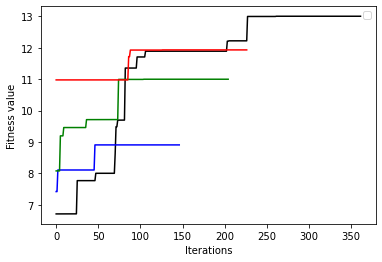

In [395]:
#plot the fitness value vs iterations
import matplotlib.pyplot as plt
plt.plot(fitness_iteratet[0],'black')
plt.plot(fitness_iteratet[1], 'blue')
plt.plot(fitness_iteratet[2], 'green')
plt.plot(fitness_iteratet[3], 'red')
plt.xlabel("Iterations")
plt.ylabel("Fitness value")
plt.legend()
plt.show()

The following output shows more information about the solution such as total duration time, commute time, idle time of each day's trip. Each day's route will be shown in detail as well.

In [390]:
#print out more information of each day's trip
day_count = 1
for chromo in solst:
    duration, commute = computeTotalTime(chromo.places)
    idle_time = 500 - duration - commute
    print ('Day ',day_count,' total duration time : ', duration, ', total commute time: ', commute, 'Idle time: ', idle_time)
    print('Overall fitness: ',chromo.fitness)
    print ('Route: home', end ='--> ')
    for place in chromo.places:
        print(place.index,'(',place.attract_level,')', end =' ---> ')
    print ('home')
    day_count +=1

Day  1  total duration time :  449 , total commute time:  38.0 Idle time:  13.0
Overall fitness:  13.003
Route: home--> 161 ( 5 ) ---> 34 ( 5 ) ---> 163 ( 5 ) ---> 136 ( 5 ) ---> home
Day  2  total duration time :  410 , total commute time:  35.0 Idle time:  55.0
Overall fitness:  8.905
Route: home--> 3 ( 4 ) ---> 21 ( 5 ) ---> 28 ( 1 ) ---> 47 ( 4 ) ---> home
Day  3  total duration time :  434 , total commute time:  34.0 Idle time:  32.0
Overall fitness:  10.997
Route: home--> 12 ( 4 ) ---> 166 ( 5 ) ---> 49 ( 5 ) ---> 42 ( 3 ) ---> home
Day  4  total duration time :  432 , total commute time:  40.0 Idle time:  28.0
Overall fitness:  11.931000000000001
Route: home--> 127 ( 5 ) ---> 71 ( 5 ) ---> 126 ( 3 ) ---> 85 ( 4 ) ---> home
Day  5  total duration time :  390 , total commute time:  68.0 Idle time:  42.0
Overall fitness:  11.817
Route: home--> 60 ( 5 ) ---> 115 ( 5 ) ---> 118 ( 5 ) ---> 4 ( 4 ) ---> home


### The following are plots of each day's route

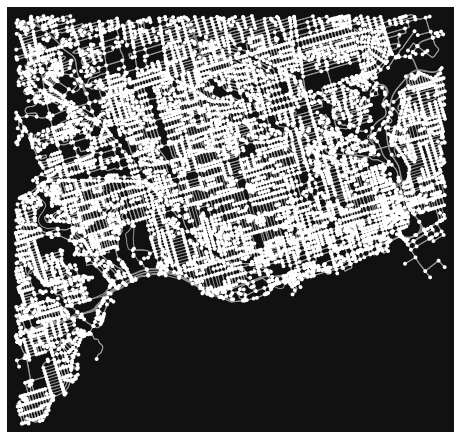

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [368]:
#use our start point as the center to create a smaller map
G2 = ox.graph_from_point((43.651,-79.42563),  dist=7000,network_type='drive')

Visualize each day's routes on the map

Route for Day  1  (the order is in red, light blue, yellow, green and dark blue)


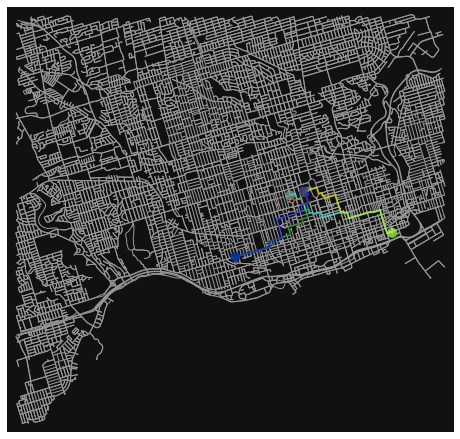

Route for Day  2  (the order is in red, light blue, yellow, green and dark blue)


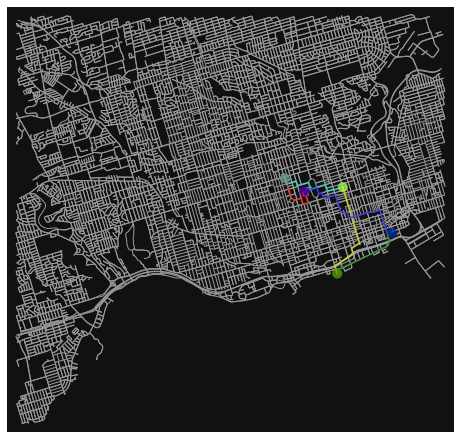

Route for Day  3  (the order is in red, light blue, yellow, green and dark blue)


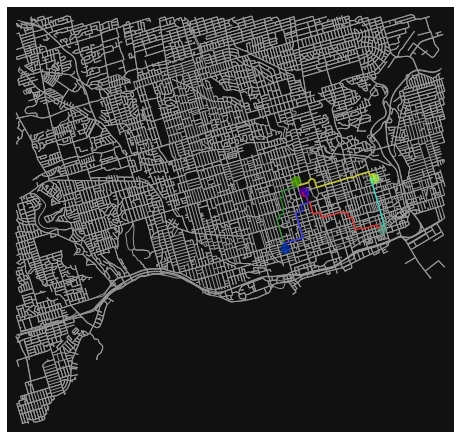

In [392]:
for i in range(3):
    print('Route for Day ', i+1,' (the order is in red, light blue, yellow, green and dark blue)')
    draw_route(solst[i].places,G2)

Route for Day  4  (the order is in red, light blue, yellow, green and dark blue)


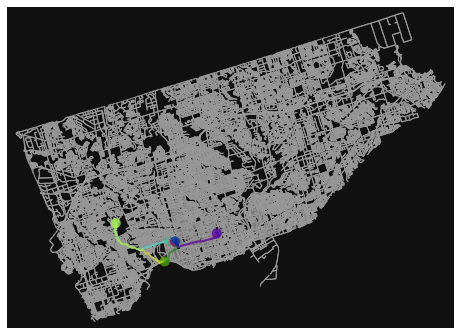

In [394]:
#since the smaller map cannot contain all points in this case, plot on Map G
print('Route for Day ', 4,' (the order is in red, light blue, yellow, green and dark blue)')
draw_route(solst[3].places,G)